In [47]:
import sys
sys.path.insert(0, r"C:\Users\noore\Desktop\research\rncstmdl\mpa_sim-PHOENIX-830_RAN_Cost_Modelling\tests")
from latency import pred_lat
from latency import lat_dist
import warnings
warnings.filterwarnings('ignore')

In [48]:
import math
from shapely.geometry import shape, Point, LineString, mapping
import numpy as np

import pandas as pd
import sys 
sys.path.append("../")
from collections import OrderedDict
from mpa_sim.services.generate_hex import produce_sites_and_site_areas
from mpa_sim.services.system_simulator import SimulationManager

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [49]:
def space(s, e, n):
    arr = [s]
    i = 1
    # r = math.exp((np.log10(e/s) / (n-1)))
    r = np.power(e/s, (1/n)) - 1
    print(r)
    while i < n:
        arr.append(arr[-1]*(1+r))
        i += 1
    return arr

In [50]:
def generate_receivers(site_area, parameters, grid):
    receivers = []

    if grid == 1:

        geom = shape(site_area[0]['geometry'])
        geom_box = geom.bounds

        minx = geom_box[0]
        miny = geom_box[1]
        maxx = geom_box[2]
        maxy = geom_box[3]

        id_number = 0

        num = int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))

        x_axis = np.array(space(minx, maxx, num))
        y_axis = np.array(space(miny, maxy, num))

        
        # x_axis = np.logspace(np.log10(minx), np.log10(maxx), num, endpoint=True)

        # y_axis = np.logspace(np.log10(miny), np.log10(maxy), num, endpoint=True)


        # x_axis = np.linspace(
        #     minx, maxx, num=(
        #         int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
        #         )
        #     )
        # y_axis = np.linspace(
        #     miny, maxy, num=(
        #         int(math.sqrt(geom.area) / (math.sqrt(geom.area)/11))
        #         )
        #     )

        xv, yv = np.meshgrid(x_axis, y_axis, sparse=False, indexing='ij')
        for i in range(len(x_axis)):
            for j in range(len(y_axis)):
                receiver = Point((xv[i,j], yv[i,j]))
                indoor_outdoor_probability = np.random.rand(1,1)[0][0]
                if geom.contains(receiver):
                    receivers.append({
                        'type': "Feature",
                        'geometry': {
                            "type": "Point",
                            "coordinates": [xv[i,j], yv[i,j]],
                        },
                        'properties': {
                            'ue_id': "id_{}".format(id_number),
                            "misc_losses": parameters['rx_misc_losses'],
                            "gain": parameters['rx_gain'],
                            "losses": parameters['rx_losses'],
                            "ue_height": float(parameters['rx_height']),
                            "indoor": (True if float(indoor_outdoor_probability) < \
                                float(0.5) else False),
                        }
                    })
                    id_number += 1

                else:
                    pass

    else:

        centroid = shape(site_area[0]['geometry']).centroid

        coord = site_area[0]['geometry']['coordinates'][0][0]
        path = LineString([(coord), (centroid)])
        length = int(path.length)
        increment = int(length / 20)

        indoor = parameters['indoor_users_percentage'] / 100

        id_number = 0
        for increment_value in range(1, 20):
            point = path.interpolate(increment * increment_value)
            indoor_outdoor_probability = np.random.rand(1,1)[0][0]
            receivers.append({
                'type': "Feature",
                'geometry': mapping(point),
                'properties': {
                    'ue_id': "id_{}".format(id_number),
                    "misc_losses": parameters['rx_misc_losses'],
                    "gain": parameters['rx_gain'],
                    "losses": parameters['rx_losses'],
                    "ue_height": float(parameters['rx_height']),
                    "indoor": (True if float(indoor_outdoor_probability) < \
                        float(indoor) else False),
                }
            })
            id_number += 1

    return receivers

In [51]:
# getting percentage of each call model in a site
call_mdl_perc = {
    "Conversational Voice": 20,
    "Conversational Video (Live Streaming)":10,
    "Video (Live Streaming) - standard": 10,
    "Video (Buffered Streaming) - standard video": 40,
    "Video (Buffered Streaming) - 4k":1,
    "Real Time Gaming": 1,
    "Voice(mp3)": 10,
    "E-mail": 8,
}
models = [mdl for mdl in call_mdl_perc]

In [52]:
def obtain_percentile_values(results, transmission_type, parameters, confidence_intervals):
    output = []

    path_loss_values = []
    received_power_values = []
    interference_values = []
    sinr_values = []
    spectral_efficiency_values = []
    estimated_capacity_values = []
    estimated_capacity_values_km2 = []

    for result in results:

        path_loss_values.append(result['path_loss'])

        received_power_values.append(result['received_power'])

        interference_values.append(result['interference'])

        sinr = result['sinr']
        if sinr == None:
            sinr = 0
        else:
            sinr_values.append(sinr)

        spectral_efficiency = result['spectral_efficiency']
        if spectral_efficiency == None:
            spectral_efficiency = 0
        else:
            spectral_efficiency_values.append(spectral_efficiency)

        estimated_capacity = result['capacity_mbps']
        if estimated_capacity == None:
            estimated_capacity = 0
        else:
            estimated_capacity_values.append(estimated_capacity)

        estimated_capacity_km2 = result['capacity_mbps_km2']
        if estimated_capacity_km2 == None:
            estimated_capacity_km2 = 0
        else:
            estimated_capacity_values_km2.append(estimated_capacity_km2)

    for confidence_interval in confidence_intervals:

        output.append({
            'confidence_interval': confidence_interval,
            'tranmission_type': transmission_type,
            'path_loss': np.percentile(
                path_loss_values, confidence_interval #<- low path loss is better
            ),
            'received_power': np.percentile(
                received_power_values, 100 - confidence_interval
            ),
            'interference': np.percentile(
                interference_values, confidence_interval #<- low interference is better
            ),
            'sinr': np.percentile(
                sinr_values, 100 - confidence_interval
            ),
            'spectral_efficiency': np.percentile(
                spectral_efficiency_values, 100 - confidence_interval
            ),
            'capacity_mbps': np.percentile(
                estimated_capacity_values, 100 - confidence_interval
            ),
            'capacity_mbps_km2': np.percentile(
                estimated_capacity_values_km2, 100 - confidence_interval
            )
        })

    return output


def get_modulation(spectral_efficiency, modulation_and_coding_lut):
    """

    Function to get spectral efficiency and modulation and coding parameters and return the modulation type.
    
    Parameters
    ----------
    spectral_efficiency : float
        Efficiency of information transfer in Bps/Hz.
    modulation_and_coding_lut : list of tuples
        A lookup table containing modulation and coding rates,
        spectral efficiencies and SINR estimates.

    Returns
    -------
    modulation : string
        Type of modulation if exist, otherwise None

    """
    for item in modulation_and_coding_lut:
        if item[5] == spectral_efficiency:
            return item[3]
    return None


In [53]:
def run_simulator(parameters, spectrum_portfolio, ant_types,
    site_radii, modulation_and_coding_lut):
    """

    Function to run the simulator and all associated modules.

    """
    unprojected_point = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': (37.3899962, -121.9757812),
            },
        'properties': {
            'site_id': 'Crystal Palace Radio Tower'
            }
        }

    unprojected_crs = 'epsg:4326'
    projected_crs = 'epsg:3857'

    environments =[
        'urban',
        'suburban',
        'rural'
    ]
    
    temp = []

    for environment in environments:
        for ant_type in ant_types:
            site_radii_generator = site_radii[ant_type]
            for site_radius in site_radii_generator[environment]:
#                 print(site_radius)

                if environment == 'urban' and site_radius > 5000:
                    continue
                if environment == 'suburban' and site_radius > 15000:
                    continue

#                 print('--working on {}: {}'.format(environment, site_radius))

                transmitter, interfering_transmitters, site_area, int_site_areas = \
                    produce_sites_and_site_areas(
                        unprojected_point['geometry']['coordinates'],
                        site_radius,
                        unprojected_crs,
                        projected_crs
                        )

                receivers = generate_receivers(site_area, PARAMETERS, 1)

                for frequency, bandwidth, generation, transmission_type in spectrum_portfolio:

#                     print('{}, {}, {}, {}'.format(frequency, bandwidth, generation, transmission_type))

                    MANAGER = SimulationManager(
                        transmitter, interfering_transmitters, ant_type,
                        receivers, site_area, PARAMETERS
                        )

                    results = MANAGER.estimate_link_budget(
                        frequency,
                        bandwidth,
                        generation,
                        ant_type,
                        transmission_type,
                        environment,
                        modulation_and_coding_lut,
                        parameters
                        )
                    
                    df = pd.DataFrame(results)
                    df = df.assign(
                        environment = environment, 
                        site_radius = site_radius, 
                        frequency = frequency, 
                        bandwidth = bandwidth, 
                        generation = generation, 
                        ant_type = ant_type, 
                        transmission_type = transmission_type,
#                         modulation = get_modulation(df['spectral_efficiency'], modulation_and_coding_lut)
                    )
                    df['modulation'] = df['spectral_efficiency'].apply(lambda se: get_modulation(se, MODULATION_AND_CODING_LUT))
                    temp.append(df)
                    
    return(pd.concat(temp, ignore_index = True))


In [54]:
PARAMETERS = {
    'iterations': 20,
    'seed_value1': 1,
    'seed_value2': 2,
    'indoor_users_percentage': 50,
    'los_breakpoint_m': 500,
    'tx_macro_baseline_height': 30,
    'tx_macro_power': 40,
    'tx_macro_gain': 16,
    'tx_macro_losses': 1,
    'tx_micro_baseline_height': 10,
    'tx_micro_power': 24,
    'tx_micro_gain': 5,
    'tx_micro_losses': 1,
    'rx_gain': 4,
    'rx_losses': 4,
    'rx_misc_losses': 4,
    'rx_height': 1.5,
    'building_height': 5,
    'street_width': 20,
    'above_roof': 0,
    'network_load': 50,
    'percentile': 50,
    'sectorization': 3,
    'mnos': 2,
    'asset_lifetime': 10,
    'discount_rate': 3.5,
    'opex_percentage_of_capex': 10,
    'signaling_overhead': 0.18, # overhead for control channels
    'modulation_compression': True,
    'ru_du_ratio': 3,
    'du_cuup_ratio': 1,
    'cucp_cuup_ratio': 1,
    'compression_ratio': {
        'QPSK': 0.06,
        '16QAM': 0.12,
        '64QAM': 0.18,
        '256QAM': 0.25,
    },
    'Numerology': 0, #µ(0)=15kHz, µ(1)=30kHz, µ(2)=60kHz
    'Bandwidth': 20, #MHz (BW(j))
    'Modulation': 256, #QAM
    # 'Number_of_cells': 4,
    'Number_of_carriers': 1,
    'Number_of_UEs': 64, # per cell
    'DL': 1544, # Mbps per cell
    'UL': 824, # Mbps per cell
    'number_of_aggregated_component_carriers': 1, # (J) max = 16
    'DL_MIMO_Layers': 2, # (v(j)) max = 8 
    'UL_MIMO_Layers': 1, # (v(j)) max = 4
    'MU_MIMO':  1, # Number of Beam with MU-MIMO Users; 
    'Number_of_logical_antenna_ports': 8, # 1/2/4/8/16. Used for fronthaul throughput only, should be higher than MIMO Layers
    'Rmax': 0.92578125, # value depends on the type of coding from 3GPP 38.212 and 3GPP 38.214 (For LDPC code maximum number is 948/1024) 
    'spectral_efficiency': 5.1152, #3GPP TS 38.214 version 15.3.0 Release 15, Table 5.1.3.1-2 (64QAM)
    'Scaling_factor' : 1, # (f(j))
    'DL_UP_ratio': 0.7, #10/14, # based on slot configuration 6:4:4 (6 dl, 4 guard, 4 ul) ref: https://jira.cec.lab.emc.com/browse/MP-4406
    'IQ_mantissa_bitwidth': 8, # per I or per Q
    'IQ_exp_bitwidth': 4,
}

In [55]:
# PARAMETERS = {
#     'iterations': 20,
#     'seed_value1': 1,
#     'seed_value2': 2,
#     'indoor_users_percentage': 50,
#     'los_breakpoint_m': 500,
#     'tx_macro_baseline_height': 30,
#     'tx_macro_power': 40,
#     'tx_macro_gain': 16,
#     'tx_macro_losses': 1,
#     'tx_micro_baseline_height': 10,
#     'tx_micro_power': 24,
#     'tx_micro_gain': 5,
#     'tx_micro_losses': 1,
#     'rx_gain': 4,
#     'rx_losses': 4,
#     'rx_misc_losses': 4,
#     'rx_height': 1.5,
#     'building_height': 5,
#     'street_width': 20,
#     'above_roof': 0,
#     'network_load': 50,
#     'percentile': 50,
#     'sectorization': 3,
#     'mnos': 2,
#     'asset_lifetime': 10,
#     'discount_rate': 3.5,
#     'opex_percentage_of_capex': 10,
#     'signaling_overhead': 0.18, # overhead for control channels
#     'modulation_compression': True,
#     'ru_du_ratio': 10,
#     'du_cu_ratio': 1,
#     'compression_ratio': {
#         'QPSK': 0.06,
#         '16QAM': 0.12,
#         '64QAM': 0.18,
#         '256QAM': 0.25,
#     },
#     'Numerology': 1, #µ(0)=15kHz, µ(1)=30kHz, µ(2)=60kHz
#     'Bandwidth': 100, #MHz (BW(j))
#     'Modulation': 256, #QAM
#     'Number_of_cells': 4,
#     'Number_of_UEs': 64, 
#     'DL': 2000, # Mbps 
#     'UL': 500, # Mbps 
#     'number_of_aggregated_component_carriers': 1, # (J) max = 16
#     'DL_MIMO_Layers': 4, # (v(j)) max = 8 
#     'UL_MIMO_Layers': 4, # (v(j)) max = 4
#     'MU_MIMO':  1, # Number of Beam with MU-MIMO Users; 
#     'Number_of_logical_antenna_ports': 4, # 1/2/4/8/16. Used for fronthaul throughput only, should be higher than MIMO Layers
#     'Rmax': 0.92578125, # value depends on the type of coding from 3GPP 38.212 and 3GPP 38.214 (For LDPC code maximum number is 948/1024) 
#     'spectral_efficiency': 7.4063, #3GPP TS 38.214 version 15.3.0 Release 15, Table 5.1.3.1-2 (256QAM)
#     'Scaling_factor' : 1, # (f(j))
#     'DL_UP_ratio': 0.7, #10/14, # based on slot configuration 6:4:4 (6 dl, 4 guard, 4 ul) ref: https://jira.cec.lab.emc.com/browse/MP-4406
#     'IQ_mantissa_bitwidth': 8, # per I or per Q
#     'IQ_exp_bitwidth': 4,
# }

SPECTRUM_PORTFOLIO = [
    (3.7, 1, '5G', '1x1'),
]

ANT_TYPE = [
    ('macro'),
    ('micro'),
]

MODULATION_AND_CODING_LUT =[
    # ETSI. 2018. ‘5G; NR; Physical Layer Procedures for Data
    # (3GPP TS 38.214 Version 15.3.0 Release 15)’. Valbonne, France: ETSI.
    # Generation MIMO CQI Index	Modulation	Coding rate
    # Spectral efficiency (bps/Hz) SINR estimate (dB)
    ('5G', '8x8', 1, 'QPSK', 78, 0.30, -6.7),
    ('5G', '8x8', 2, 'QPSK', 193, 2.05, -4.7),
    ('5G', '8x8', 3, 'QPSK', 449, 4.42, -2.3),
    ('5G', '8x8', 4, '16QAM', 378, 6.40, 0.2),
    ('5G', '8x8', 5, '16QAM', 490, 8.00, 2.4),
    ('5G', '8x8', 6, '16QAM', 616, 10.82, 4.3),
    ('5G', '8x8', 7, '64QAM', 466, 12.40, 5.9),
    ('5G', '8x8', 8, '64QAM', 567, 16.00, 8.1),
    ('5G', '8x8', 9, '64QAM', 666, 19.00, 10.3),
    ('5G', '8x8', 10, '64QAM', 772, 22.00, 11.7),
    ('5G', '8x8', 11, '64QAM', 873, 28.00, 14.1),
    ('5G', '8x8', 12, '256QAM', 711, 32.00, 16.3),
    ('5G', '8x8', 13, '256QAM', 797, 38.00, 18.7),
    ('5G', '8x8', 14, '256QAM', 885, 44.00, 21),
    ('5G', '8x8', 15, '256QAM', 948, 50.00, 22.7),
]

unprojected_point = {
    'type': 'Feature',
    'geometry': {
        'type': 'Point',
        'coordinates': (37.3899962, -121.9757812), #Great America Parkway, Santa Clara, CA 95054-1231, United States of America
        },
    'properties': {
        'site_id': 'Crystal Palace Radio Tower'
        }
    }



## Cost Model

In [56]:
COSTS = {
    #all costs in $USD
    'cpu': [
        {
            'model': '6148',
            'price': 2988.39,
            'cores': 20,
            'power': 150,
        },
        {
            'model': '6230',
            'price': 1582.72,
            'cores': 26,
            'power': 150,
        },
    ],
    'switch': [
        {
            'model': '10GB Fiber',
            'price': 2000,
            'ports': 8,
            'power': 150,
            'speed': 10, #Gbps
        },
        {
            'model': '25GB Fiber',
            'price': 8000,
            'ports': 8,
            'power': 350,
            'speed': 25, #Gbps
        },
    ],
    'server': [
        {
            'model': 'XR11',
            'price': 900,
            'size': '1U',
            'power': 150,
            'cpu_max': 2,
            'pcie_max': 4,
        },
        {
            'model': 'R750',
            'price': 1700,
            'size': '2U',
            'power': 200,
            'cpu_max': 2,
            'pcie_max': 4,
        },
    ],
    'lease_line_installation': [
        {
            'model': '1Gbps',
            'price': 1000,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 2000,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 10000,
            'speed': 100, #Gbps
        },
    ],
    'lease_line_installation_per_meter': [
        {
            'model': '1Gbps',
            'price': 0.1,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 0.2,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 0.3,
            'speed': 100, #Gbps
        },
    ],
    'lease_line_rental': [
        {
            'model': '1Gbps',
            'price': 500,
            'speed': 1, #Gbps
        },
        {
            'model': '10Gbps',
            'price': 5000,
            'speed': 10, #Gbps
        },        
        {
            'model': '100Gbps',
            'price': 15000,
            'speed': 100, #Gbps
        },
    ],
    'sfp': [
        {
            'model': 'QSPF28',
            'price': 599, #usd
            'distance': 10000, #meters
            'speed': 100, #Gbps
        },
        {
            'model': 'SPF28',
            'price': 420, #usd
            'distance': 30000, #meters
            'speed': 25, #Gbps
        },
        {
            'model': 'Dell SPF',
            'price': 115, #usd
            'distance': 300, #meters
            'speed': 10, #Gbps
        },
    ],
    'single_sector_antenna': [
        {
            'price': 1500
        },
    ],
    'ru': [
        {
            'price': 4000
        },
    ],
    'du': [
        {
            'price': 10000
        },
    ],
    'cu': [
        {
            'price': 15000
        },
    ],
    'tower': [
        {
            'price': 10000
        },
    ],
    'transportation': [
        {
            'price': 10000
        },
    ],
    'installation': [
        {
            'price': 5000
        },
    ],
    'site_rental': [
        {
            'price': 8000
        },
    ],
    'power_generator_battery_system': [
        {
            'price': 5000
        },
    ],
    'smo': [
        {
            'price': 2000
        },
    ],    
    'l1_controller': [
        {
            'model': 'marvell',
            'price': 900,
            'ports': 4,
            'speed': 10, # Gbps
        },
    ],

}


In [57]:
from mpa_sim.services.hw_estimator import CPU_forecasting_model
from mpa_sim.services.costs import Cost
import pickle as pl

In [58]:
cost_obj = Cost(simulation_parameters = PARAMETERS, cost_parameters = COSTS)
cpu_fm = CPU_forecasting_model(simulation_parameters = PARAMETERS)

In [59]:
frequency, bandwidth, generation, transmission_type = SPECTRUM_PORTFOLIO[0]
ant_type = "macro"
environment = "urban"

site_radius = 500 # meters

Number_of_sits_per_km2 = cost_obj.get_sites_per_km2(site_radius)
Number_of_cells_per_km2 = Number_of_sits_per_km2 * PARAMETERS["sectorization"]
Number_of_ues_per_km2 = Number_of_cells_per_km2 * PARAMETERS['Number_of_UEs']
Number_of_sits_per_km2, Number_of_cells_per_km2, Number_of_ues_per_km2

(1.1547005383792517, 3.4641016151377553, 221.70250336881634)

In [60]:
unprojected_point = {
    'type': 'Feature',
    'geometry': {
        'type': 'Point',
        'coordinates': (37.3899962, -121.9757812),
        },
    'properties': {
        'site_id': 'Crystal Palace Radio Tower'
        }
    }

unprojected_crs = 'epsg:4326'
projected_crs = 'epsg:3857'

In [61]:
transmitter, interfering_transmitters, site_area, int_site_areas = \
    produce_sites_and_site_areas(
        unprojected_point['geometry']['coordinates'],
        site_radius,
        unprojected_crs,
        projected_crs
        )

In [62]:
interferences_x, interferences_y = [], []
for int_trans in interfering_transmitters:
    interferences_x.append(int_trans['geometry']['coordinates'][0])
    interferences_y.append(int_trans['geometry']['coordinates'][1])
receivers = generate_receivers(site_area, PARAMETERS, 1) 

-6.6949147298212e-06
2.3359936993871955e-05


# Call Model Based Hexagon generation and Individual Latency Prediction

In [63]:
receivers[0]

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-13579190.940161657, 4493499.781898719]},
 'properties': {'ue_id': 'id_0',
  'misc_losses': 4,
  'gain': 4,
  'losses': 4,
  'ue_height': 1.5,
  'indoor': True}}

In [64]:
# getting percentage of each call model in a site
call_mdl_perc = {
    "Conversational Voice": 20,
    "Conversational Video (Live Streaming)":10,
    "Video (Live Streaming) - standard": 10,
    "Video (Buffered Streaming) - standard video": 40,
    "Video (Buffered Streaming) - 4k":1,
    "Real Time Gaming": 1,
    "Voice(mp3)": 10,
    "E-mail": 8,
}
models = [mdl for mdl in call_mdl_perc]

In [66]:
# assiging the call model to each ue (sequentially)
prev=0
for i, mdl in enumerate(call_mdl_perc):
    bound = math.ceil((len(receivers)*(call_mdl_perc[mdl]))/100)
    for r in receivers[prev:prev+bound]:
        r['call model'] = mdl
    prev += bound

In [67]:
receivers[0]

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [-13579190.940161657, 4493499.781898719]},
 'properties': {'ue_id': 'id_0',
  'misc_losses': 4,
  'gain': 4,
  'losses': 4,
  'ue_height': 1.5,
  'indoor': True},
 'call model': 'Conversational Voice'}

In [68]:
def hex_latency(err_rate):
    lookup = pd.read_excel("../../power_dimensioning/callmodel.xlsx")
    mdl_lat = []

    for ue in receivers:
        ue['dist'] = math.pow(((ue['geometry']['coordinates'][0] - transmitter[0]['geometry']['coordinates'][0])**2 + \
                (ue['geometry']['coordinates'][1] - transmitter[0]['geometry']['coordinates'][1])**2), 0.5)
    
        rsc_type = lookup[lookup['Services'] == ue['call model']]['resource type'].reset_index(drop=True)[0]
        prior_lvl = lookup[lookup['Services'] == ue['call model']]['priority level'].reset_index(drop=True)[0]

        mdl_lat.append(pred_lat([rsc_type, prior_lvl, err_rate, mdl]) + lat_dist(ue['dist']))
    return mdl_lat

In [69]:
err_rate = 0.00001
hex_latency(err_rate)[:5]

[array([100.00000246]),
 array([100.00000222]),
 array([100.00000208]),
 array([100.00000208]),
 array([100.00000222])]

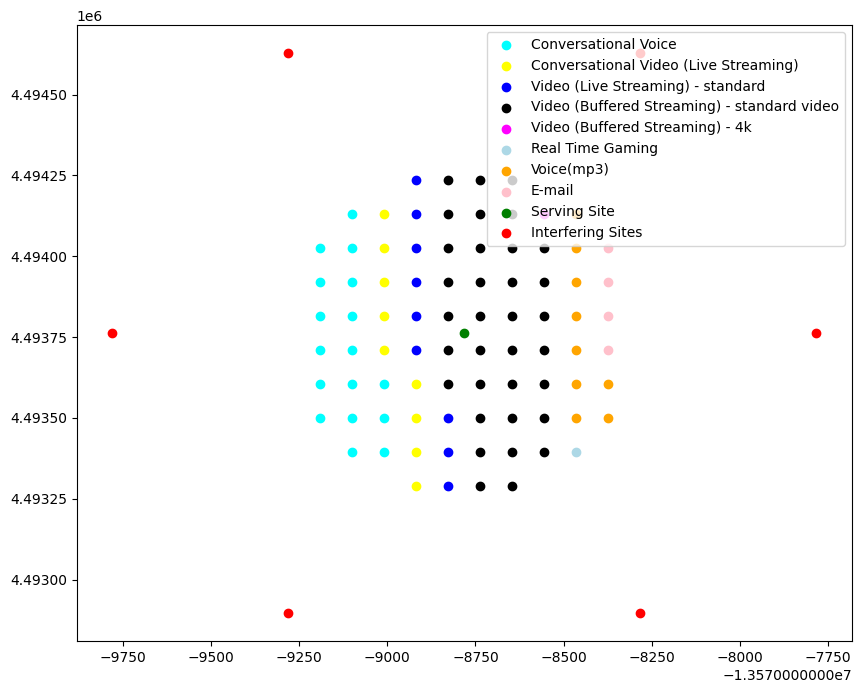

In [82]:
X, Y  = [[None] for _ in range(len(call_mdl_perc))]  , [[None] for _ in range(len(call_mdl_perc))] 
prev = 0
for i, mdl in enumerate(call_mdl_perc):
    bound = math.ceil((len(receivers)*(call_mdl_perc[mdl]))/100)
    for r in receivers[prev:prev+bound]:
        X[i].append(r['geometry']['coordinates'][0])
        Y[i].append(r['geometry']['coordinates'][1])
    prev += bound
plt.figure(figsize=(10,8))   

colors = ['cyan', 'yellow', 'blue', 'black', 'magenta', 'lightblue', 'orange', 'pink']

for i in range(len(X)):
    plt.scatter(X[i],Y[i], color = colors[i], label=models[i])

plt.scatter(transmitter[0]['geometry']['coordinates'][0],transmitter[0]['geometry']['coordinates'][1], color='green', label="Serving Site")
plt.scatter(interferences_x,interferences_y, color = 'red', label="Interfering Sites")
plt.legend()
plt.show()

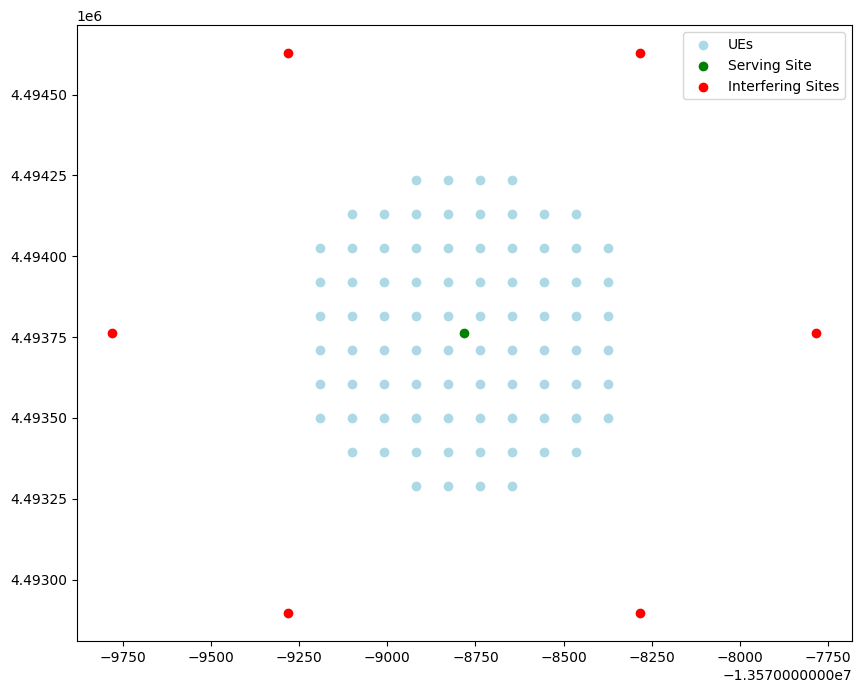

In [71]:
X, Y = [] , []
for r in receivers:
    X.append(r['geometry']['coordinates'][0])
    Y.append(r['geometry']['coordinates'][1])
plt.figure(figsize=(10,8))    
plt.scatter(X,Y, color = 'lightblue', label="UEs")
plt.scatter(transmitter[0]['geometry']['coordinates'][0],transmitter[0]['geometry']['coordinates'][1], color='green', label="Serving Site")
plt.scatter(interferences_x,interferences_y, color = 'red', label="Interfering Sites")
plt.legend()
plt.show()

In [72]:
MANAGER = SimulationManager(
    transmitter, interfering_transmitters, 
    ant_type,
    receivers, site_area, PARAMETERS
    )

results = MANAGER.estimate_link_budget(
    frequency,
    bandwidth,
    generation,
    ant_type,
    transmission_type,
    environment,
    MODULATION_AND_CODING_LUT,
    PARAMETERS
    )

df = pd.DataFrame(results)
df = df.assign(
    environment = environment, 
    site_radius = site_radius, 
    frequency = frequency, 
    bandwidth = bandwidth, 
    generation = generation, 
    ant_type = ant_type, 
    transmission_type = transmission_type,
#                         modulation = get_modulation(df['spectral_efficiency'], modulation_and_coding_lut)
)
df['modulation'] = df['spectral_efficiency'].apply(lambda se: get_modulation(se, MODULATION_AND_CODING_LUT))
df.head(10)
#df.to_csv("traffic_info.csv")

,id,path_loss,r_model,type_of_sight,ave_inf_pl,received_power,distance,interference,i_model,network_load,ave_distance,noise,i_plus_n,tranmission_type,sinr,spectral_efficiency,modulation,capacity_mbps,capacity_mbps_km2,receiver_x,receiver_y,fronthaul_capacity_mbps,signaling_overhead_mbps,environment,site_radius,frequency,bandwidth,generation,ant_type,transmission_type
0,id_0,103,etsi_tr_138_901,los,146.000000,-52.0,486.044083,-87.259637,etsi_tr_138_901,50,1060.455548,-112.477229,-87.259637,1x1,35.26,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.493500e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
1,id_1,99,etsi_tr_138_901,los,142.833333,-48.0,438.357255,-84.296709,etsi_tr_138_901,50,1048.805283,-112.477229,-84.296709,1x1,36.30,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.493605e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
2,id_2,98,etsi_tr_138_901,los,143.000000,-47.0,412.445833,-83.301030,etsi_tr_138_901,50,1042.865255,-112.477229,-83.301030,1x1,36.30,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.493710e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
3,id_3,101,etsi_tr_138_901,los,146.000000,-50.0,412.436472,-86.301030,etsi_tr_138_901,50,1042.863160,-112.477229,-86.301030,1x1,36.30,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.493815e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
4,id_4,99,etsi_tr_138_901,los,142.833333,-48.0,438.332591,-84.296709,etsi_tr_138_901,50,1048.799497,-112.477229,-84.296709,1x1,36.30,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.493920e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
5,id_5,100,etsi_tr_138_901,los,143.000000,-49.0,486.012306,-84.259637,etsi_tr_138_901,50,1060.447480,-112.477229,-84.259637,1x1,35.26,50.0,256QAM,50.0,57.735027,-1.357919e+07,4.494025e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
6,id_6,103,etsi_tr_138_901,los,146.000000,-52.0,486.043852,-84.301030,etsi_tr_138_901,50,1059.786476,-112.477229,-84.301030,1x1,32.30,50.0,256QAM,50.0,57.735027,-1.357910e+07,4.493395e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
7,id_7,98,etsi_tr_138_901,los,143.000000,-47.0,412.458667,-84.300596,etsi_tr_138_901,50,1043.105555,-112.477229,-84.300596,1x1,37.30,50.0,256QAM,50.0,57.735027,-1.357910e+07,4.493500e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
8,id_8,97,etsi_tr_138_901,los,143.166667,-46.0,355.021667,-86.259637,etsi_tr_138_901,50,1031.838789,-112.477229,-86.259637,1x1,40.26,50.0,256QAM,50.0,57.735027,-1.357910e+07,4.493605e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1
9,id_9,99,etsi_tr_138_901,los,146.166667,-48.0,322.482351,-89.300592,etsi_tr_138_901,50,1026.147724,-112.477229,-89.300592,1x1,41.30,50.0,256QAM,50.0,57.735027,-1.357910e+07,4.493710e+06,12.5,9.0,urban,500,3.7,1,5G,macro,1x1


In [73]:
required_DL_capacity_at_ru_mbps = df['fronthaul_capacity_mbps'].sum() + df['signaling_overhead_mbps'].sum()
required_UL_capacity_at_ru_mbps = required_DL_capacity_at_ru_mbps / 4
required_DL_capacity_at_ru_mbps

1806.0

In [74]:
PARAMETERS["Number_of_cells"] = Number_of_cells_per_km2
PARAMETERS["Number_of_UEs"] = Number_of_ues_per_km2
PARAMETERS["DL"] = required_DL_capacity_at_ru_mbps
PARAMETERS["UL"] = required_UL_capacity_at_ru_mbps

In [75]:
model_CU, model_DU, scaler = cpu_fm.loadModels()
fi = open("data_res.plk", "rb")
res = pl.load(fi)
fi.close()
res

{'DU_utils': 125.92865995564433,
 'CUCP_utils': 194.7727762431615,
 'CUUP_utils': 194.81405784642513}

In [76]:
res = cost_obj.get_cost(
    sites_per_km2 = Number_of_sits_per_km2, 
    capacity_gbps = required_DL_capacity_at_ru_mbps, 
    rudu_distance=15000, 
    ducu_distance=10000,    
    CUCP_utils = res['CUCP_utils'], 
    CUUP_utils = res['CUUP_utils'],
    DU_utils = res['DU_utils'])


In [77]:
res['cost_breakdown']

{'single_sector_antenna': 9668.837533402097,
 'ru': 25783.566755738917,
 'tower': 11547.005383792517,
 'transportation': 11547.005383792517,
 'installation': 5773.5026918962585,
 'site_rental': 79514.40196791933,
 'power_generator_battery_system': 10743.152814891215,
 'fiber_switch': 17189.044503825946,
 'sfp_ru': 504.1243297309859,
 'sfp_sectors': 756.1864945964788,
 'eCPRI_leased_line_capex': 31155.143163184523,
 'eCPRI_leased_line_opex': 149089.50368984873,
 'f1u_leased_line_capex': 27932.197318717164,
 'f1u_leased_line_opex': 149089.50368984873,
 'f1c_leased_line_capex': 27932.197318717164,
 'f1c_leased_line_opex': 149089.50368984873,
 'l1_controller': 483.44187667010476,
 'cucp_cpu': 2333.6348340605327,
 'cucp_server': 338.8524474060738,
 'cuup_cpu': 2333.9019282686772,
 'cuup_server': 338.8926671878509,
 'du_cpu': 1530.3948655327133,
 'du_server': 241.96119886126425}

In [78]:
res['components_breakdown']

{'single_sector_antenna': 3.0,
 'ru': 3.0,
 'tower': 1.0,
 'power_generator_battery_system': 1.0,
 'fiber_switch': 1.0,
 'sfp': 6.0,
 'eCPRI_Throughput(Gbps)': 10.086451199999999,
 'f1u_Throughput(Gbps)': 13328.28,
 'f1c_Throughput(Gbps)': 2925.72,
 'l1_controller': 0.75,
 'cucp_cpu': 0.36519895545592784,
 'cucp_server': 0.18259947772796392,
 'cuup_cpu': 0.3652763584620471,
 'cuup_server': 0.18263817923102355,
 'du_cpu': 0.23611623741683316,
 'du_server': 0.11805811870841658}

In [79]:
total_cost = round(sum(res['cost_breakdown'].values()),2)
print('Cost Per Square Kilometer: ${:5,.2f}'.format(total_cost))
print('Cost Per Square meter: ${:5,.2f}'.format(total_cost/10**6))

Cost Per Square Kilometer: $714,915.96
Cost Per Square meter: $ 0.71


In [80]:
res['components_breakdown']['eCPRI_Throughput(Gbps)']/res['components_breakdown']['ru']

3.3621503999999995

In [81]:
res['components_breakdown']['f1u_Throughput(Gbps)'] + res['components_breakdown']['f1c_Throughput(Gbps)'] 

16254.0